In [16]:
# NGSolve Libraries
from netgen.geom2d import unit_square
from ngsolve.meshes import MakeStructured2DMesh, MakeStructured3DMesh
from ngsolve import *
from ngsolve.webgui import Draw # para jupyter
#import netgen.gui
from netgen.occ import *
from netgen.csg import *
from netgen.geom2d import SplineGeometry
import sys
sys.path.insert(0,"../")
import problems
import numpy as np
import params
import pickle
from time import time
import pandas as pd
import scipy
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

In [17]:
def gen_latex_table(df, caption, label):
    """Generates a LaTeX table from a pandas DataFrame."""
    latex_table = df.to_latex(index=False, caption=caption, label=label, float_format="%.4e")
    return latex_table

In [18]:
def get_custom_frobenius_norm(A,theta):
   return A[0,0]**2 + A[1,1]**2 + (1/theta**2) * A[0,1]**2 + theta**2 * A[1,0]**2


In [19]:
## get problem parameters and geometry
problem = problems.problem4
phi0 = problem[0]['phi0']
chi = problem[0]['chi']
G_target = problem[0]['G']
geom = "../"+problem[1]
dim = problem[0]['dim']
BC = problem[2]
name = problem[-1]
h = 0.05
ord = 2
N = params.N
KBTV = params.KBTV
form = "Functional" # EDP //functional

rho = 1.23e-6
gel_measures = [[15.0,90,1.62],[23.5,90,3.0]]

G = Parameter(G_target)

def reference_energy(lambda1,lambda2,lambda3):
    G=G_target
    nu = KBTV
    J= lambda1*lambda2*lambda3
    return 0.5*G*(lambda1**2 + lambda2**2 + lambda3**2) + nu*((J-phi0)*np.log(1-phi0/J) + phi0*chi*(1-phi0/J))

def dH( J):
        return phi0/J + np.log(1-phi0/J) + chi * (phi0/J)**2
def aux_isotropic(s):
    return s*dH(s*s*s) + G_target/KBTV

l_iso = (scipy.optimize.fsolve(aux_isotropic, 1.7))[0]

reference_energy_val = reference_energy(l_iso,l_iso,l_iso)
def H_scalar(J):
        return (J - phi0) * np.log(1-phi0/J) + phi0*chi*(1-phi0/J)
def lambda_uni(lamb):
        return G_target*0.5*(2+lamb**2)+KBTV*H_scalar(lamb)
    
l_uni = minimize_scalar(lambda_uni,bounds=(0,2),method='bounded').x
def auxFunctionUniaxial(s):
    gamma = G_target/(KBTV)
    return dH(s) +gamma*s

def run_experiment(delta,measures,n_delta,h = 0.05):
    delta = np.round(delta,2)
    w,l,d = measures
    theta = w/l

    mapping_first_mesh = lambda x,y: ((x*(0.5 - delta/2)) +delta/2, y-0.5)
    mesh = MakeStructured2DMesh(
        nx=(19-n_delta)*2, ny=2*int(1/h), mapping=mapping_first_mesh, quads=False)
    Draw(mesh)

    def Gel_energy_functional(u,beta):
            Grad_custom = CF((Grad(u)[0,0], (1/theta)*Grad(u)[0,1],
                            theta*Grad(u)[1,0], Grad(u)[1,1]),dims=(2,2))
            F = Id(2) + Grad_custom
            J = Det(F) * beta
            phi = phi0/J
            H = (J - phi0)*log(1-phi)  + phi0 * chi*(1-phi)
            return 0.5*(G)* (get_custom_frobenius_norm(F,theta) + beta**2) + H * KBTV 
    def energy_functional(F):
        J = Det(F)
        C = F.trans* F
    
        G = G_target
      
        H = lambda J: (J - phi0) * log(1-phi0/J) + phi0*chi*(1-phi0/J)
        
        return 0.5*G*(Trace(C)) + KBTV * H(J) -  reference_energy_val


    ## Generate spaces and forms
    """
    To bond the gel go to geometries and describe the bonding
    face there, not here.
    """
    fesu = VectorH1(mesh, order = ord, dirichlet = "left")
    fesbeta = H1(mesh, order = ord)
    fes = FESpace([fesu, fesbeta])
    u, beta = fes.TrialFunction()
    BF = BilinearForm(fes)
    gfu = GridFunction(fes)
    gfu.components[0].Set((0,0))
    gfu.components[1].Set(1)
    BF += Variation(Gel_energy_functional(u,beta).Compile()*dx)
    ##### solve with newton
    max_iter_newton = 150
    newton_damp = 0.3
    softening_n = 150

    tol_newton = 1e-8
    gammas = np.flip(np.linspace(G_target, G_target*20 ,softening_n))

    for num in range(len(gammas)):
        G.Set(gammas[num])
        res = gfu.vec.CreateVector()
        w_vec = gfu.vec.CreateVector()
        for iter in range(max_iter_newton):
            with TaskManager():
                BF.Apply(gfu.vec,res)
                BF.AssembleLinearization(gfu.vec)
                inv = BF.mat.Inverse(freedofs= fes.FreeDofs())
                w_vec.data = newton_damp * inv * res
            gfu.vec.data += -w_vec
            if abs(InnerProduct(w_vec,res)) < tol_newton:
                break 

    gfu2 = GridFunction(fesu)
    gfu2.components[0].Set(gfu.components[0].components[1])
    gfu2.components[1].Set(gfu.components[0].components[0])

    
    def H_scalar(J):
        return (J - phi0) * np.log(1-phi0/J) + phi0*chi*(1-phi0/J)

    def lambda_uni(lamb):
        return G_target*0.5*(2+lamb**2)+KBTV*H_scalar(lamb)
    
    l_uni = minimize_scalar(lambda_uni,bounds=(0,4),method='bounded').x
    h = 1.0
    mapping_unit_cube = lambda x,y,z: ((1/2)*x,y-0.5 , z)
    mapping_phisical_gel = lambda x ,y ,z: (x*l/2, -w/2 + y*w, z*d)

    mesh_unit_cube = MakeStructured3DMesh(nx=200, ny=int(w/h), nz=int(d/h),mapping=mapping_unit_cube, hexes = False)
    mesh_phisical_gel = MakeStructured3DMesh(
        nx=200, ny=int(w/h), nz=int(d/h),
        mapping=mapping_phisical_gel, hexes= False)
    
    
    mesh_center = MakeStructured3DMesh(
        nx=200, ny=int(w/h), nz=int(d/h),
        mapping=lambda x,y,z: (-l*delta/2 + x*l*delta, -w/2 + y*w, z*d), hexes= False)
    
    mesh_wing_cube = MakeStructured3DMesh(
        nx=200, ny=int(w/h), nz=int(d/h),
        mapping=lambda x,y,z: (delta/2 + x*(1-delta)/2, -1/2 + y, z), hexes= False)
    
    aux_z = IfPos(-delta/2+x, z,0)
    
    # create the gridfunctions for the different meshes
    fes_unit_cube = VectorH1(mesh_wing_cube, order=ord)
    gfu_unit_cube = GridFunction(fes_unit_cube)
    gfu_unit_cube.components[0].Set(gfu.components[0].components[0])
    gfu_unit_cube.components[1].Set(gfu.components[0].components[1])
    gfu_unit_cube.components[2].Set(z * gfu.components[1]- aux_z)
    
    fes_center = VectorH1(mesh_center, order=ord)   
    gfu_center = GridFunction(fes_center)
    gfu_center.components[2].Set((l_uni-1) * z)

    fesu_3d = VectorH1(mesh_unit_cube, order=ord)
    gfu3d = GridFunction(fesu_3d)
    gfu3d.components[0].Set(gfu.components[0].components[0])
    gfu3d.components[1].Set(gfu.components[0].components[1])
    gfu3d.components[2].Set(z*gfu.components[1]-aux_z)
    
    phisical_gel_fes = VectorH1(mesh_phisical_gel, order=ord)
    phisical_gel_gfu = GridFunction(phisical_gel_fes)
    phisical_gel_gfu.components[0].vec.data = l*gfu3d.components[0].vec
    phisical_gel_gfu.components[1].vec.data = w*gfu3d.components[1].vec
    phisical_gel_gfu.components[2].vec.data = d*gfu3d.components[2].vec

    gfu_aux = GridFunction(phisical_gel_fes)
    gfu_aux.components[2].Set(IfPos(delta*l/2-x, (l_uni-1)*z,0))
    gfu_final = gfu_aux + phisical_gel_gfu

    with TaskManager():
         # calculate (a)
        a_measure = gfu_final(mesh_phisical_gel(l/2,w/2,0))[1] - gfu_final(mesh_phisical_gel(l/2,-w/2,0))[1] + w 
        # calculate (b)
        b_measure = w # direct since uniaxial deformation in this section.
        # calculate (c)
        c_measure = 2 * (gfu_final(mesh_phisical_gel(l/2,0,0))[0]+(1-delta)*l/2) + l*delta
        # calculate (d)
        d_measure = gfu_final(mesh_phisical_gel(l/2,0,d))[2]
        # calculate (e)
        e_measure = gfu_final(mesh_phisical_gel(0,0,d))[2] 

        F_center = Id(3) + Grad(gfu_center)
        F_center_wing = Id(3) + Grad(gfu_final)
        energy_center = GridFunction(H1(mesh_phisical_gel, order=1))
        energy_density_center_wing = GridFunction(H1(mesh_phisical_gel, order=1))
        energy_center.Set(energy_functional(F_center))
        energy_density_center_wing.Set(energy_functional(F_center_wing))
        total_energy = 2 * Integrate(energy_density_center_wing,mesh_phisical_gel,order=5) 
    # calculate average energy
    avg_energy = total_energy/(l*w*d)
   
    
    # generate plot and save it 
    # show the linear regression 
    return {
        'delta': delta,
        'a': a_measure,
        'b': b_measure,
        'c': c_measure,
        'd': d_measure,
        'e': e_measure,
        'total_energy': total_energy,
        'avg_energy': avg_energy*1000
        }, gfu_final, mesh_phisical_gel


Running experiments for measures: [15.0, 90, 1.62]


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.05, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.05), 'a': 22.311889254721127, 'b': 15.0, 'c': np.float64(131.75805499277155), 'd': 0.7895966429883953, 'e': 1.6078224840519415, 'total_energy': 33.79866989956402, 'avg_energy': 15.45435294904619}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.1, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.1), 'a': 22.312049546678058, 'b': 15.0, 'c': np.float64(129.56566574036907), 'd': 0.7896345477642035, 'e': 1.6078224840519415, 'total_energy': 50.24957936767984, 'avg_energy': 22.976488051065314}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.15000000000000002, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.15), 'a': 22.310990810911292, 'b': 15.0, 'c': np.float64(127.36457265218107), 'd': 0.7894514772186583, 'e': 1.6078224840519415, 'total_energy': 66.60206213445547, 'avg_energy': 30.453617802677396}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.2, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.2), 'a': 22.292811646022585, 'b': 15.0, 'c': np.float64(125.11742540779136), 'd': 0.7890874447862616, 'e': 1.6078224840519415, 'total_energy': 90.24235765805805, 'avg_energy': 41.26308077643258}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.25, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.25), 'a': 22.309927263841942, 'b': 15.0, 'c': np.float64(122.97591404326667), 'd': 0.7894510543075074, 'e': 1.6078224840519415, 'total_energy': 99.86810870641337, 'avg_energy': 45.66443013553423}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.30000000000000004, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.3), 'a': 22.312480913078296, 'b': 15.0, 'c': np.float64(120.79233883094064), 'd': 0.7896429805725746, 'e': 1.6078224840519415, 'total_energy': 116.6179224392651, 'avg_energy': 53.32323842673301}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.35000000000000003, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.35), 'a': 22.309689471511177, 'b': 15.0, 'c': np.float64(118.58958795052467), 'd': 0.7894510489572346, 'e': 1.6078224840519415, 'total_energy': 133.09851977521345, 'avg_energy': 60.85894822826403}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.4, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.4), 'a': 22.30968661448453, 'b': 15.0, 'c': np.float64(116.3966766899375), 'd': 0.7894510396367852, 'e': 1.6078224840519415, 'total_energy': 149.72546287011673, 'avg_energy': 68.46157424330899}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.45, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.45), 'a': 22.31025200653837, 'b': 15.0, 'c': np.float64(114.20346612496186), 'd': 0.7893695489073586, 'e': 1.6078224840519415, 'total_energy': 166.38802693830328, 'avg_energy': 76.080487854734}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.5, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.5), 'a': 22.30893505986826, 'b': 15.0, 'c': np.float64(112.00860540553408), 'd': 0.7893694530289036, 'e': 1.6078224840519415, 'total_energy': 182.97125029352435, 'avg_energy': 83.66312313375599}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.55, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.55), 'a': 22.309019819591015, 'b': 15.0, 'c': np.float64(109.81604688060807), 'd': 0.7893694635268188, 'e': 1.6078224840519415, 'total_energy': 199.59512218631696, 'avg_energy': 91.26434484971055}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.6000000000000001, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.6), 'a': 22.308948761676064, 'b': 15.0, 'c': np.float64(107.6232717106234), 'd': 0.7893694630124908, 'e': 1.6078224840519415, 'total_energy': 216.21866737475688, 'avg_energy': 98.86541718095879}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.65, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.65), 'a': 22.30891962662394, 'b': 15.0, 'c': np.float64(105.43056250008576), 'd': 0.7893694490525008, 'e': 1.6078224840519415, 'total_energy': 232.84270355743627, 'avg_energy': 106.46671401803214}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.7000000000000001, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.7), 'a': 22.310289929492733, 'b': 15.0, 'c': np.float64(103.23823207027078), 'd': 0.7892536655309369, 'e': 1.6078224840519415, 'total_energy': 249.45113346631024, 'avg_energy': 114.06087492743951}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.75, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.75), 'a': 22.308026593362136, 'b': 15.0, 'c': np.float64(101.04371789512032), 'd': 0.7892512214533666, 'e': 1.6078224840519415, 'total_energy': 266.08824528232856, 'avg_energy': 121.66815056347899}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.8, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.8), 'a': 22.3078306708106, 'b': 15.0, 'c': np.float64(98.85122406131202), 'd': 0.789251924810693, 'e': 1.6078224840519415, 'total_energy': 282.7115088333214, 'avg_energy': 129.26909411674504}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.8500000000000001, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.85), 'a': 22.307980416740065, 'b': 15.0, 'c': np.float64(96.65900882660756), 'd': 0.7892600867672747, 'e': 1.6078224840519415, 'total_energy': 299.3358904746584, 'avg_energy': 136.87054891388132}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.9, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.9), 'a': 22.303477618951618, 'b': 15.0, 'c': np.float64(94.46486952100273), 'd': 0.789283445990418, 'e': 1.6078224840519415, 'total_energy': 315.9548751344654, 'avg_energy': 144.46953595540256}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.9500000000000001, Measures: [15.0, 90, 1.62], Results: {'delta': np.float64(0.95), 'a': 22.710482086197892, 'b': 15.0, 'c': np.float64(92.31976198332066), 'd': 0.7669754265412094, 'e': 1.6078224840519415, 'total_energy': 332.47098267201534, 'avg_energy': 152.02148270325347}
Slope: 329.911127729368, Intercept: 18.25972614915951
Running experiments for measures: [23.5, 90, 3.0]


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.05, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.05), 'a': 34.95290271313859, 'b': 23.5, 'c': np.float64(131.81160669341594), 'd': 1.4619471971648963, 'e': 2.9774490445406423, 'total_energy': 107.94130678719822, 'avg_energy': 17.012026286398456}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.1, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.1), 'a': 34.95182950809879, 'b': 23.5, 'c': np.float64(129.61668583067762), 'd': 1.4619468881141646, 'e': 2.9774490445406423, 'total_energy': 156.18899369844075, 'avg_energy': 24.616074656964656}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.15, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.15), 'a': 34.951805235991515, 'b': 23.5, 'c': np.float64(127.42374677158793), 'd': 1.4619468860875573, 'e': 2.9774490445406423, 'total_energy': 204.42488071474705, 'avg_energy': 32.218263312016866}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.2, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.2), 'a': 34.95663022866549, 'b': 23.5, 'c': np.float64(125.24206570201056), 'd': 1.4623069497010903, 'e': 2.9774490445406423, 'total_energy': 252.69668357627614, 'avg_energy': 39.82611246277008}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.25, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.25), 'a': 34.95182065218178, 'b': 23.5, 'c': np.float64(123.03797735880906), 'd': 1.4619468891461178, 'e': 2.9774490445406423, 'total_energy': 300.8967598774822, 'avg_energy': 47.422657191092554}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.3, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.3), 'a': 34.951809160332076, 'b': 23.5, 'c': np.float64(120.8450584197171), 'd': 1.4619464010218286, 'e': 2.9774490445406423, 'total_energy': 349.13286063618716, 'avg_energy': 55.02487953289002}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.35, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.35), 'a': 34.956504212283065, 'b': 23.5, 'c': np.float64(118.6612391461564), 'd': 1.4622831061473192, 'e': 2.9774490445406423, 'total_energy': 397.51538288169303, 'avg_energy': 62.65017854715414}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.4, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.4), 'a': 34.95178708598854, 'b': 23.5, 'c': np.float64(116.45923978137225), 'd': 1.4619463690881065, 'e': 2.9774490445406423, 'total_energy': 445.6046519467882, 'avg_energy': 70.22925956608167}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.45, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.45), 'a': 34.950745776126325, 'b': 23.5, 'c': np.float64(114.26399727597342), 'd': 1.4617953286285759, 'e': 2.9774490445406423, 'total_energy': 493.8350184830801, 'avg_energy': 77.83057816912216}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.5, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.5), 'a': 34.95060950041765, 'b': 23.5, 'c': np.float64(112.07117619171015), 'd': 1.4617949021282266, 'e': 2.9774490445406423, 'total_energy': 542.0710316812804, 'avg_energy': 85.43278671099769}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.55, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.55), 'a': 34.951275665026714, 'b': 23.5, 'c': np.float64(109.87911187944427), 'd': 1.4617955288106683, 'e': 2.9774490445406423, 'total_energy': 590.3066679965493, 'avg_energy': 93.0349358544601}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.6, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.6), 'a': 34.95054666257701, 'b': 23.5, 'c': np.float64(107.68583549490812), 'd': 1.4618003064590568, 'e': 2.9774490445406423, 'total_energy': 638.5430976475892, 'avg_energy': 100.63721003114092}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.65, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.65), 'a': 34.9500291145519, 'b': 23.5, 'c': np.float64(105.49308757421875), 'd': 1.4618394581850322, 'e': 2.9774490445406423, 'total_energy': 686.7791530703175, 'avg_energy': 108.23942522778843}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.7, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.7), 'a': 34.94823483444597, 'b': 23.5, 'c': np.float64(103.30005949391477), 'd': 1.4619649175061653, 'e': 2.9774490445406423, 'total_energy': 735.0153282051049, 'avg_energy': 115.84165929158469}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.75, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.75), 'a': 34.94635467710498, 'b': 23.5, 'c': np.float64(101.10511886029525), 'd': 1.4616912883275281, 'e': 2.9774490445406423, 'total_energy': 783.2437740625587, 'avg_energy': 123.4426751871645}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.8, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.8), 'a': 34.98359112604317, 'b': 23.5, 'c': np.float64(98.91628242395146), 'd': 1.4585525101140815, 'e': 2.9774490445406423, 'total_energy': 831.4749102755653, 'avg_energy': 131.04411509465174}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.85, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.85), 'a': 35.232873335600395, 'b': 23.5, 'c': np.float64(96.76490525334825), 'd': 1.440238399381869, 'e': 2.9774490445406423, 'total_energy': 879.5934791460352, 'avg_energy': 138.62781389220413}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.9, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.9), 'a': 35.93954854288466, 'b': 23.5, 'c': np.float64(94.73951180876361), 'd': 1.393132214057073, 'e': 2.9774490445406423, 'total_energy': 927.8717442437338, 'avg_energy': 146.236681519895}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Delta: 0.95, Measures: [23.5, 90, 3.0], Results: {'delta': np.float64(0.95), 'a': 35.033971254989645, 'b': 23.5, 'c': np.float64(92.75799619780086), 'd': 1.470788137456156, 'e': 2.9774490445406423, 'total_energy': 979.5761347142758, 'avg_energy': 154.38552162557536}
Slope: 964.6969220433272, Intercept: 59.7352126053764


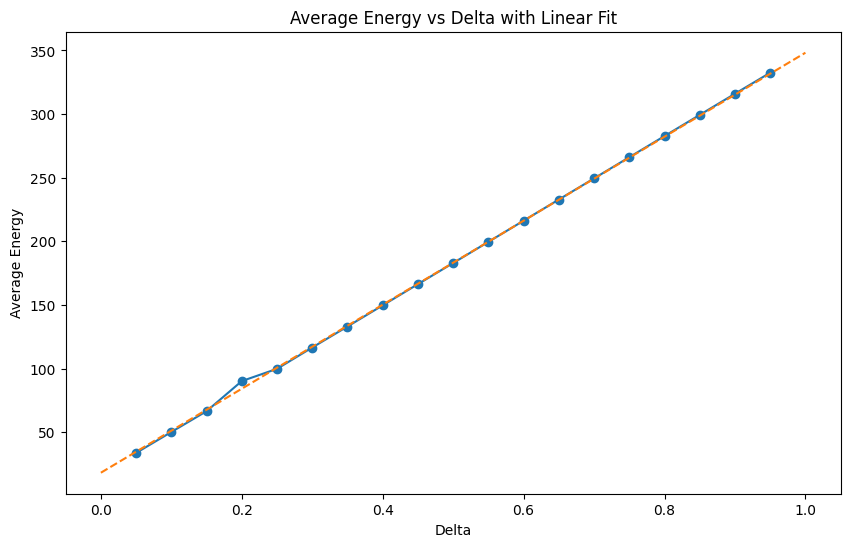

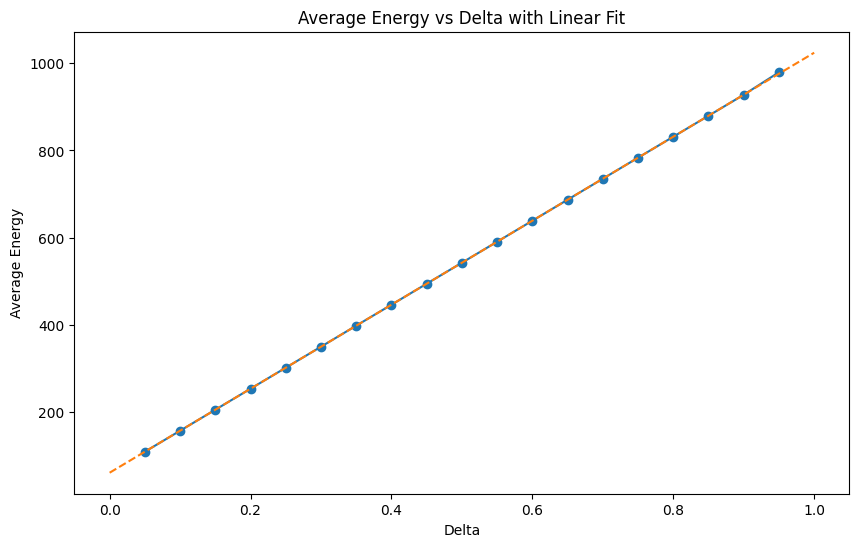

In [20]:
def run_all_experiments(deltas, measures):
    for measure in measures:
        print(f"Running experiments for measures: {measure}")
        results = []
        for n_delta, delta in enumerate(deltas):
            res, gfu_final, mesh_phisical_gel = run_experiment(delta, measure,n_delta ,h=0.1)
            results.append(res)
            print(f"Delta: {delta}, Measures: {measure}, Results: {res}")
        results = pd.DataFrame(results)
        caption = f"Results for measures {measure} with varying delta"
        label = f"tab:results_{measure[0]}_{measure[1]}_{measure[2]}"
        latex_table = gen_latex_table(results, caption, label)
        # save table
        with open(f"results_{measure[0]}_{measure[1]}_{measure[2]}.tex", "w") as f:
            f.write(latex_table)    
        deltas = results['delta'].values
        avg_energy = results['total_energy'].values
        # get slope
        slope, intercept = np.polyfit(deltas[:-5], avg_energy[:-5], 1)
        #plot polyfit
        plt.figure(figsize=(10, 6))
        plt.plot(deltas, avg_energy, marker='o', label='Average Energy')
        x = np.linspace(0,1,100)
        plt.plot(x, slope * x + intercept, label='Linear Fit', linestyle='--')
        plt.title('Average Energy vs Delta with Linear Fit')
        plt.xlabel('Delta')
        plt.ylabel('Average Energy')
        plt.savefig(f"average_energy_vs_delta_{measure[0]}_{measure[1]}_{measure[2]}.png")
        print(f"Slope: {slope}, Intercept: {intercept}")
run_all_experiments(np.arange(0.05,1,0.05), gel_measures)
        

Latex resumen del experimento
hacer para w, d = 23.5 /15, 3, 1.62
subir foto a overleaf
reportar resultados actuales.

cambiar a make structrured mesh
mostrar algunas mallas en paraview
comparar foto contra ecuación 24 y 25 del paper (último) y figuras de cortes transversales (fig 11)
comparar abcde  modelo reducido y 3D (pedir las soluciones) actualizar github :) 

In [21]:
import numpy as np
x = np.arange(0.05,1,0.05)
print(x)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]
